Link: https://www.youtube.com/watch?v=U0s0f995w14&t=162s

aid understanding about attention machanism 

*NOTE that this tutorial is not working properly. It's a representation of how Transformers architecture works in details. But maybe it's missing some here and there. Read Chapt 11 in Deep Dive To DL for precise implementation*

In [1]:
import torch
import torch.nn as nn

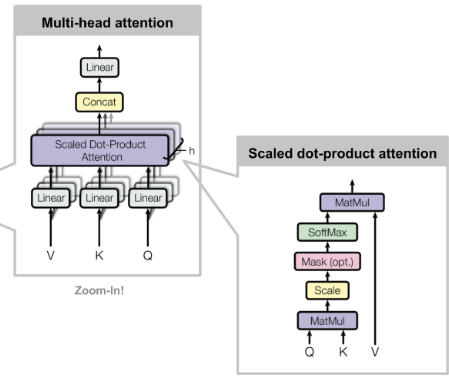

In [2]:
#Attention: This is very important and hard to gasp

class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.head_dim = embed_size // heads
    assert (self.head_dim * heads == embed_size), 'embed_size must be divisible by heads'

    self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)

    #concat the to feed to another Linear transformation 
    #embed_size = self.head_dim * self.heads
    self.fc_out = nn.Linear(embed_size, embed_size)

  def forward(self, values, keys, queries, mask):
    #N = batch size
    #v = value_len
    #k = key_len
    #q = query_len
    #h = heads
    #d = head_dim
    #embed_size = h * d
    N = values.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

    #split the values, keys, and queries
    #values shape ( N, v, h, d)
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    #keys shape (N, k, h, d)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    #queris shape (N, q, h, d)
    queries = queries.reshape(N, query_len, self.heads, self.head_dim)

    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)
    
    #Q matmul K --> (nqhd) x (nkhd) --> (nhqk)
    energy = torch.einsum('nqhd,nkhd->nhqk', [queries, keys])

    #Scale and add mask 
    if mask:
      energy = energy.masked_fill(mask == 0, float('-inf'))

    #Pass to softmax
    attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim = 3)

    #attention matmul with values: (nhqk) x (nvhd) --> nqhd. Note that k and v are the same value so we can use letter l for them 
    output = torch.einsum('nhql,nlhd->nqhd', [attention, values])

    #Now concat them together into (N, q, h * d) <-- Flatten the last 2 dimension. Note that h * d == embed_size
    output = output.reshape(N, query_len, self.heads * self.head_dim)

    out = self.fc_out(output)

In [3]:
#Sample
attention = SelfAttention(8,2)

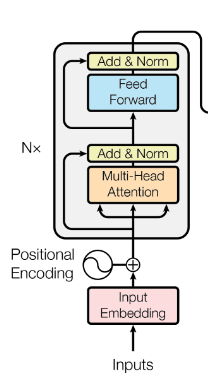

In [4]:
#Transformer Block
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout, forward_expansion):
    super(TransformerBlock, self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.dropout = dropout
    self.forward_expansion = forward_expansion

    self.attention = SelfAttention(embed_size, heads)

    self.norm1 = nn.LayerNorm(self.embed_size)
    self.norm2 = nn.LayerNorm(self.embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, embed_size * forward_expansion),
        nn.ReLU(),
        nn.Linear(embed_size * forward_expansion, embed_size)
    )

    self.dropout = nn.Dropout(dropout)

  def forward(self, values, keys, query, mask):
    attention = self.attention(values, keys, query, mask)
    x = self.dropout(self.norm1(attention + query))
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x))
    return out


In [5]:
t = TransformerBlock(8,2,0.1,4)

In [10]:
#Encoder block
class EncoderBlock(nn.Module):
  def __init__(self, 
               vocab_size, 
               embed_size, 
               num_layers,
               heads,
               forward_expansion,
               dropout,
               max_length,
               device
               ):

    super(EncoderBlock, self).__init__()
          
    self.vocab_size = vocab_size, 
    self.embed_size = embed_size, 
    self.num_layers = num_layers,
    self.heads = heads,
    self.forward_expansion = forward_expansion,
    self.dropout = dropout,
    self.max_length = max_length
    self.device = device

    #init embedding layer
    self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)

    #in the paper
    self.positional_embedding = nn.Embedding(self.max_length ,self.embed_size)

    #construct the architecte of encoder
    self.layers = nn.ModuleList(
        [
            TransformerBlock(
                self.embed_size,
                self.heads,
                self.dropout,
                self.forward_expansion
            )
        for _ in range(self.num_layers)]
    )

    self.dropout = nn.Dropout(self.dropout)

  def forward(self, X, mask):
    N, sequence_len = X.shape

    #I don't understand this part. google it
    positions = torch.arange(0, sequence_len).expand(N, sequence_len).to(self.device)

    out = self.dropout(self.word_embedding(X) + self.positional_embedding(positions))

    for layer in self.layers:
      out = layer(out, out, out, mask)
    
    return out
    



    

In [11]:
#@title Default title text
vocab_size = 10 #@param {type:"number"}
embed_size = 8 #@param {type:"number"}
num_layers = 1 #@param {type:"number"}
heads = 2 #@param {type:"number"}
forward_expansion = 4 #@param {type:"number"}
dropout = 0.15 #@param {type:"number"}
max_length = 10 #@param {type:"number"}

encoder = EncoderBlock(vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length)


TypeError: ignored

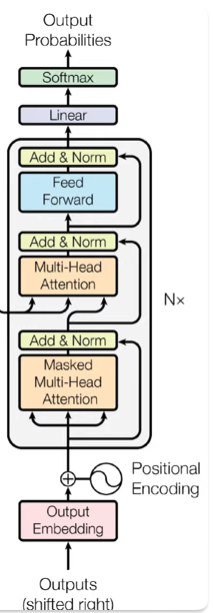

In [14]:
#Decoder Block
class DecoderBlock(nn.Module):
  def __init__(
      self,
      embed_size,
      heads,
      forward_expansion,
      dropout,
      device):

      self.attention = SelfAttention(embed_size, heads)
      self.norm = nn.LayerNorm(embed_size)
      self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)
      self.dropout = nn.Dropout(dropout)
  def forward(self, x, value, key, src_mask, tgt_mask):
    #src mask is optional used for padding to make more than 1 examples have the same length
    attention = self.attention(x,x,x,tgt_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformer_block(value, key, query, src_mask)
    return out


#Decoder component
class Decoder(nn.Module):
  def __init__(
      self, 
      tgt_vocab_size, 
      embed_size, 
      num_layers,
      heads,
      forward_expansion,
      dropout,
      max_length,
      device
      ):
      super(Decoder, self).__init__()
      self.device = device
      self.word_embedding = nn.Embedding(tgt_vocab_size, embed_size)
      self.position_embedding = nn.Embedding(max_length, embed_size)

      self.layers = nn.ModuleList([
          DecoderBlock(embed_size, heads, forward_expansion, device)
          for _ in range(num_layers)])
        
      self.fc_out = nn.Linear(embed_size, tgt_vocab_size)
      self.dropout = nn.Dropout(dropout)
    
  def forward(self, x, enc_out, src_mask, tgt_mask):
    N, seq_length = x.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, src_mask, tgt_mask)
    
    out = self.fc_out(x)

    return out
  



    

In [ ]:
class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      tgt_vocab_size, 
      #pad size used to compute mask 
      src_pad_index, 
      tgt_pad_index,
      embed_size = 256,
      num_layers = 6,
      forward_expansion = 4,
      heads = 8,
      dropout = 0,
      max_length = 100,
      device='cuda'
    ):
    super(Transformer, self).__init__()
    self.encoder = EncoderBlock(
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        max_length,
        device
    )

    self.decoder = Decoder(
        tgt_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        max_length,
        device
    )

    self.src_pad_index = src_pad_index 
    self.tgt_pad_index = tgt_pad_index 
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_index).unsqueeze(1).unsqueeze(2) 
    return src_mask.to(self.device)
  
  def make_tgt_mask(self, tgt):
    N, tgt_len = tgt.shape
    tgt_mask = torch.tril(torch.ones((tgt_len, tgt_len))).expand(N, 1, tgt_len, tgt_len)
    return tgt_mask.to(self.device)

  def forward(self, src, tgt):
    src_mask = self.make_src_mask(src)
    tgt_mask = self.make_tgt_mask(tgt)
    enc_src = self.ecoder(src, src_mask)
    out = self.decoder(enc_src, src_mask, tgt_mask)
    return out
  
  



    